## NYC COVID-19 Cases & Population Health Status

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd

import mapclassify as mc
from sklearn.preprocessing import scale
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns; sns.set()
import geoplot

In [2]:
#Population based on 2010 population census

nyc_population =  pd.read_csv("data/uhf_population2010.csv")

nyc_population = nyc_population[['United Hospital Fund (UHF 42) neighborhood, 2009', 'Borough', 'Total population, 2010']]

nyc_population.rename(columns = {'United Hospital Fund (UHF 42) neighborhood, 2009': 'neighborhood',
                                'Borough': 'borough',
                                'Total population, 2010': 'population'}, inplace = True)
nyc_population.head()

,neighborhood,borough,population
0,Kingsbridge - Riverdale,Bronx,94095
1,Northeast Bronx,Bronx,190315
2,Fordham - Bronx Pk,Bronx,250249
3,Pelham - Throgs Neck,Bronx,297059
4,Crotona-Tremont,Bronx,206630


In [3]:
test_by_zip = pd.read_csv("data/tests-by-zcta.csv", dtype= {'MODZCTA': str} )

test_by_zip = test_by_zip[1:]
test_by_zip.reset_index(drop = True, inplace = True)

test_by_zip.head()

,MODZCTA,Positive,Total,zcta_cum.perc_pos
0,10001,321,1130,28.41
1,10002,931,2457,37.89
2,10003,414,1549,26.73
3,10004,28,108,25.93
4,10005,54,256,21.09


In [4]:
uhf42_zipcodes = pd.read_csv("data/uhf42_zipcodes.csv")

uhf42_zipcodes['uhf42_neigh'] = uhf42_zipcodes['Neighborhood'].str.strip()

uhf42_zipcodes.head()

,Borough,Neighborhood,ZIP Codes,uhf42_neigh
0,Bronx,Fordham - Bronx Pk,"10458, 10467, 10468",Fordham - Bronx Pk
1,Bronx,Kingsbridge - Riverdale,"10463, 10471",Kingsbridge - Riverdale
2,Bronx,Northeast Bronx,"10466, 10469, 10470, 10475",Northeast Bronx
3,Bronx,Pelham - Throgs Neck,"10461, 10462, 10464, 10465, 10472, 10473",Pelham - Throgs Neck
4,Bronx,Hunts Point - Mott Haven,"10454, 10455, 10459, 10474",Hunts Point - Mott Haven


In [5]:
uhf34_zipcodes = pd.read_csv("data/uhf34_zipcodes.csv")

uhf34_zipcodes['uhf34_neigh'] = uhf34_zipcodes['Neighborhood'].str.strip()

uhf34_zipcodes.head()

,Borough,Neighborhood,ZIP Codes,uhf34_neigh
0,Bronx,Fordham - Bronx Pk,"10458, 10467, 10468",Fordham - Bronx Pk
1,NaN,Kingsbridge - Riverdale,"10463, 10471",Kingsbridge - Riverdale
2,NaN,Northeast Bronx,"10466, 10469, 10470, 10475",Northeast Bronx
3,NaN,Pelham - Throgs Neck,"10461, 10462, 10464, 10465, 10472, 10473",Pelham - Throgs Neck
4,NaN,South Bronx,"10451, 10452, 10453, 10454, 10455, 10456, 1045...",South Bronx


In [6]:
# MODZCTA_neighborhood = pd.concat([pd.Series(row['Neighborhood'], row['ZIP Codes'].split(',')) for _, row in uhf34_zipcodes.iterrows()]).reset_index()

# MODZCTA_neighborhood.rename(columns = {'index': 'zipcode', 0: 'neighborhood'}, inplace = True)

# MODZCTA_neighborhood.head()

In [7]:
#Mapping zipcodes to their  neighborhood

def uhf34zip_mapping(zipcode):
    neigh = uhf34_zipcodes['Neighborhood'][uhf34_zipcodes["ZIP Codes"].str.contains(zipcode)]
    return neigh.values
    
def uhf42zip_mapping(zipcode):
    neigh = uhf42_zipcodes['Neighborhood'][uhf42_zipcodes["ZIP Codes"].str.contains(zipcode)]
    return neigh.values
        
test_by_zip['MODZCTA'] = test_by_zip['MODZCTA'].str.strip()

test_by_zip['uhf34_neigh'] = test_by_zip['MODZCTA'].apply(uhf34zip_mapping)
test_by_zip['uhf42_neigh'] = test_by_zip['MODZCTA'].apply(uhf42zip_mapping)


test_by_zip['uhf34_neigh'] = test_by_zip['uhf34_neigh'].apply(lambda x: str(x).replace("['","").replace("']",""))
test_by_zip['uhf42_neigh'] = test_by_zip['uhf42_neigh'].apply(lambda x: str(x).replace("['","").replace("']",""))

test_by_zip.head()

,MODZCTA,Positive,Total,zcta_cum.perc_pos,uhf34_neigh,uhf42_neigh
0,10001,321,1130,28.41,Chelsea-Village,Chelsea-Clinton
1,10002,931,2457,37.89,Union Square-Lower Manhattan,Union Square - Lower East Side
2,10003,414,1549,26.73,Union Square-Lower Manhattan,Union Square - Lower East Side
3,10004,28,108,25.93,Union Square-Lower Manhattan,Lower Manhattan
4,10005,54,256,21.09,Union Square-Lower Manhattan,Lower Manhattan


Zip code treatment for missing fields:

In [8]:
test_by_zip[test_by_zip['uhf34_neigh'] == '[]']

,MODZCTA,Positive,Total,zcta_cum.perc_pos,uhf34_neigh,uhf42_neigh
79,10474,301,725,41.52,[],Hunts Point - Mott Haven
124,11238,692,1887,36.67,[],Bedford Stuyvesant - Crown Heights
147,11378,675,1741,38.77,[],West Queens


In [9]:
test_by_zip.iloc[79,4] = 'South Bronx'
test_by_zip.iloc[124,4] = 'Bedford Stuyvesant - Crown Heights'
test_by_zip.iloc[147,4] = 'West Queens'

In [10]:
test_by_zip[test_by_zip['uhf42_neigh'] == '[]']

,MODZCTA,Positive,Total,zcta_cum.perc_pos,uhf34_neigh,uhf42_neigh
38,10065,303,1341,22.60,Upper East Side-Gramercy,[]
39,10069,49,198,24.75,Upper West Side,[]
40,10075,348,1217,28.59,Upper East Side-Gramercy,[]
43,10282,64,197,32.49,Union Square-Lower Manhattan,[]


In [11]:
test_by_zip.iloc[38,5] = 'Upper East Side'
test_by_zip.iloc[39,5] = 'Upper West Side'
test_by_zip.iloc[40,5] = 'Upper East Side'
test_by_zip.iloc[43,5] = 'Union Square - Lower East Side'

In [12]:
#MODZCTA and Neighborhoods for mapping later

MODZCTA_neighbohood = test_by_zip[['MODZCTA', 'uhf34_neigh', 'uhf42_neigh']]

MODZCTA_neighbohood.head()

,MODZCTA,uhf34_neigh,uhf42_neigh
0,10001,Chelsea-Village,Chelsea-Clinton
1,10002,Union Square-Lower Manhattan,Union Square - Lower East Side
2,10003,Union Square-Lower Manhattan,Union Square - Lower East Side
3,10004,Union Square-Lower Manhattan,Lower Manhattan
4,10005,Union Square-Lower Manhattan,Lower Manhattan


In [13]:
case_per_neighborhood = pd.DataFrame(test_by_zip.groupby(['uhf34_neigh','uhf42_neigh']).sum()).reset_index()


case_per_neighborhood['positive_rate'] = np.round(case_per_neighborhood['Positive']/case_per_neighborhood['Total']*100,2)

case_per_neighborhood = case_per_neighborhood[['uhf34_neigh','uhf42_neigh', 'Positive', 'positive_rate', 'Total']]

case_per_neighborhood.head()

,uhf34_neigh,uhf42_neigh,Positive,positive_rate,Total
0,Bayside Little Neck-Fresh Meadows,Bayside - Little Neck,1236,35.44,3488
1,Bayside Little Neck-Fresh Meadows,Fresh Meadows,2061,39.06,5277
2,Bedford Stuyvesant - Crown Heights,Bedford Stuyvesant - Crown Heights,5393,39.09,13795
3,Bensonhurst - Bay Ridge,Bensonhurst - Bay Ridge,3020,37.38,8079
4,Borough Park,Borough Park,8054,38.58,20878


In [14]:
def merge_df(df1, df2, left_on, right_on):
    
    return df1.merge(df2,
                     left_on =left_on,
                     right_on = right_on).drop(columns=[right_on])

In [15]:
#Merging population data

case_per_neighborhood = merge_df(case_per_neighborhood, nyc_population[['neighborhood','borough', 'population']],
                                                     left_on = 'uhf42_neigh',
                                                     right_on='neighborhood')

case_per_neighborhood.rename(columns={"Neighborhood": "neighborhood", 
                                      "Total": "total_test"}, inplace= True)

case_per_neighborhood['case_per_capita'] = np.round(case_per_neighborhood['Positive']/ case_per_neighborhood['population'],
                                                    3)
case_per_neighborhood['test_per_capita'] = np.round(case_per_neighborhood['total_test']/ case_per_neighborhood['population'],
                                                    3)

case_per_neighborhood = case_per_neighborhood[['borough', 
                                               'uhf34_neigh',
                                               'uhf42_neigh', 
                                               'population', 
                                               'positive_rate',
                                               'case_per_capita',
                                               'test_per_capita']]


case_per_neighborhood.head()

,borough,uhf34_neigh,uhf42_neigh,population,positive_rate,case_per_capita,test_per_capita
0,Queens,Bayside Little Neck-Fresh Meadows,Bayside - Little Neck,87423,35.44,0.014,0.040
1,Queens,Bayside Little Neck-Fresh Meadows,Fresh Meadows,95537,39.06,0.022,0.055
2,Brooklyn,Bedford Stuyvesant - Crown Heights,Bedford Stuyvesant - Crown Heights,316269,39.09,0.017,0.044
3,Brooklyn,Bensonhurst - Bay Ridge,Bensonhurst - Bay Ridge,201541,37.38,0.015,0.040
4,Brooklyn,Borough Park,Borough Park,322563,38.58,0.025,0.065


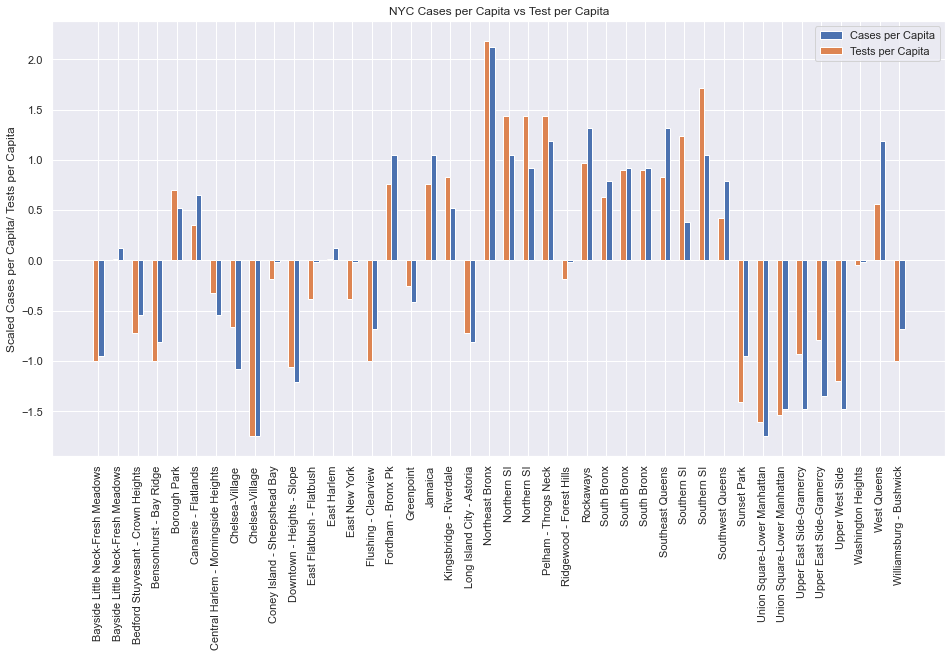

In [16]:
labels = case_per_neighborhood['uhf34_neigh'] #UHF34 Neighborhoods

x = np.arange(len(labels))  # the label locations
width = 0.275  # the width of the bars


scaled_positive_rate = scale(case_per_neighborhood['case_per_capita'])
scaled_test_per_capita = scale(case_per_neighborhood['test_per_capita'])

fig, ax = plt.subplots(figsize=(16, 8))
rects1 = ax.bar(x + width/2, scaled_positive_rate, width, label='Cases per Capita')
rects2 = ax.bar(x - width/2, scaled_test_per_capita, width, label='Tests per Capita')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scaled Cases per Capita/ Tests per Capita')
ax.set_title('NYC Cases per Capita vs Tests per Capita')
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.xticks(rotation=90)

ax.legend()

plt.show()

The graph shows that some neighborhoods are potentially undertested (e.g. West Queens, Rockaways) or overtested (e.g.  Knightbrigde, Borough Park).

In [17]:
obesity = pd.read_csv("data/overweight_obese.csv")

obesity.iloc[:,0] = obesity.copy().iloc[:,0].str.strip()

obesity.head()

,Geography,Indicator Name,Number,Percent
0,New York City,Overweight or Obese Adults,"3,692,000",57.4
1,Bronx,Overweight or Obese Adults,"720,000",69.3
2,Brooklyn,Overweight or Obese Adults,"1,132,000",58.2
3,Manhattan,Overweight or Obese Adults,"582,000",44.4
4,Queens,Overweight or Obese Adults,"1,037,000",58.2


In [18]:
case_per_neighborhood = merge_df(case_per_neighborhood, obesity[['Geography','Percent']],
                                                     left_on = 'uhf34_neigh',
                                                     right_on='Geography')

case_per_neighborhood.rename(columns = {'Percent': "obesity_percent"}, inplace= True)

case_per_neighborhood.head()

,borough,uhf34_neigh,uhf42_neigh,population,positive_rate,case_per_capita,test_per_capita,obesity_percent
0,Queens,Bayside Little Neck-Fresh Meadows,Bayside - Little Neck,87423,35.44,0.014,0.040,53.4
1,Queens,Bayside Little Neck-Fresh Meadows,Fresh Meadows,95537,39.06,0.022,0.055,53.4
2,Brooklyn,Bedford Stuyvesant - Crown Heights,Bedford Stuyvesant - Crown Heights,316269,39.09,0.017,0.044,67.2
3,Brooklyn,Bensonhurst - Bay Ridge,Bensonhurst - Bay Ridge,201541,37.38,0.015,0.040,50.3
4,Brooklyn,Borough Park,Borough Park,322563,38.58,0.025,0.065,56.3


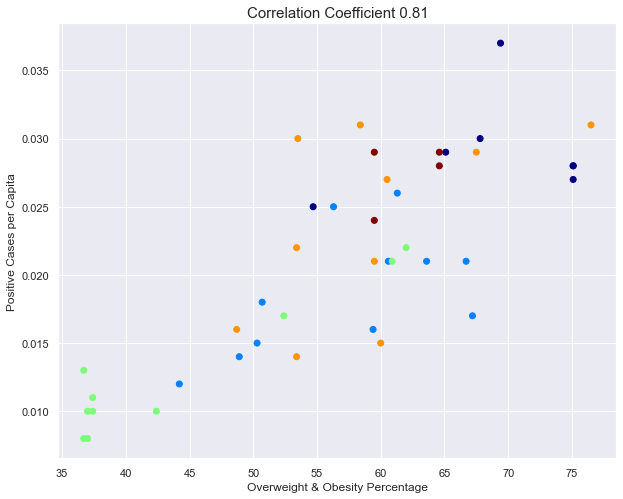

In [19]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(case_per_neighborhood['obesity_percent'],case_per_neighborhood['case_per_capita'],
            c= case_per_neighborhood['borough'].astype('category').cat.codes, 
            cmap = 'jet')

corr_coef = np.round(np.corrcoef(case_per_neighborhood['case_per_capita'],case_per_neighborhood['obesity_percent'])[0,1],3)

ax.set_title('Correlation Coefficient {}'.format(corr_coef), fontsize=15)
ax.set_xlabel('Overweight & Obesity Percentage', fontsize=12)
ax.set_ylabel('Positive Cases per Capita', fontsize=12)

plt.show()

There is some strong positive correlation between obesity rate and postive COVID cases across neighborhoods.

In [20]:
# excercise = pd.read_csv("data/exercise_2017.csv")

# excercise.iloc[:,2] = excercise.copy().iloc[:,2].str.strip()

# excercise.head()

In [21]:
# case_per_neighborhood = merge_df(case_per_neighborhood, excercise[['Geography','Percent']], 
#                                  left_on = 'uhf34_neigh',
#                                  right_on='Geography')

# case_per_neighborhood.rename(columns = {'Percent': "excercise_percent"}, inplace= True)

# case_per_neighborhood.head()

In [22]:
# fig, ax = plt.subplots(figsize=(10, 8))

# ax.scatter(case_per_neighborhood['excercise_percent'],case_per_neighborhood['case_per_capita'],
#             c= case_per_neighborhood['borough'].astype('category').cat.codes, 
#             cmap = 'jet')

# corr_coef = np.round(np.corrcoef(case_per_neighborhood['case_per_capita'],case_per_neighborhood['excercise_percent'])[0,1],3)

# ax.set_title('Correlation Coefficient {}'.format(corr_coef), fontsize=15)
# ax.set_xlabel('Regular Excercise Percentage', fontsize=12)
# ax.set_ylabel('Positive Cases per Capita', fontsize=12)

# plt.show()

There is some medium-strong negative correlation between excercise rate and postive COVID cases across neighborhoods.

In [23]:
copd = pd.read_csv("data/copd_2016.csv")

copd.iloc[:,1] = copd.copy().iloc[:,1].str.strip()

copd.head()

,Borough,Geography,Indicator Name,"Age-Adjusted Rate (per 10,000 residents)","Estimated Annual Rate (per 10,000 residents)",Number
0,Bronx,Fordham - Bronx Pk,Chronic Obstructive Pulmonary Disease Hospita...,51.3,45.5,600
1,Bronx,Kingsbridge - Riverdale,Chronic Obstructive Pulmonary Disease Hospita...,37.5,33.8,546
2,Bronx,Northeast Bronx,Chronic Obstructive Pulmonary Disease Hospita...,54.2,52.1,707
3,Bronx,Pelham - Throgs Neck,Chronic Obstructive Pulmonary Disease Hospita...,56.9,53.5,467
4,Bronx,Hunts Point - Mott Haven,Chronic Obstructive Pulmonary Disease Hospita...,17.9,22.3,148


In [24]:
case_per_neighborhood = merge_df(case_per_neighborhood, copd[['Geography','Age-Adjusted Rate (per 10,000 residents)']], 
                                 left_on = 'uhf42_neigh',
                                 right_on='Geography')

case_per_neighborhood.rename(columns = {'Age-Adjusted Rate (per 10,000 residents)': "copd_rate"}, inplace= True)

case_per_neighborhood.head()

,borough,uhf34_neigh,uhf42_neigh,population,positive_rate,case_per_capita,test_per_capita,obesity_percent,copd_rate
0,Queens,Bayside Little Neck-Fresh Meadows,Bayside - Little Neck,87423,35.44,0.014,0.040,53.4,11.7
1,Queens,Bayside Little Neck-Fresh Meadows,Fresh Meadows,95537,39.06,0.022,0.055,53.4,12.0
2,Brooklyn,Bedford Stuyvesant - Crown Heights,Bedford Stuyvesant - Crown Heights,316269,39.09,0.017,0.044,67.2,21.4
3,Brooklyn,Bensonhurst - Bay Ridge,Bensonhurst - Bay Ridge,201541,37.38,0.015,0.040,50.3,40.8
4,Brooklyn,Borough Park,Borough Park,322563,38.58,0.025,0.065,56.3,15.5


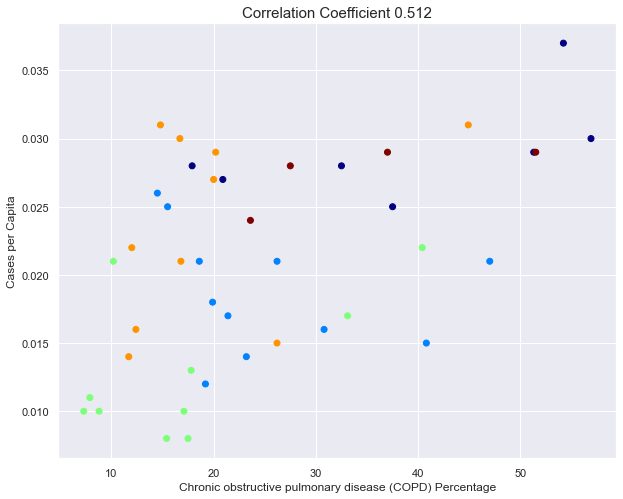

In [25]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(case_per_neighborhood['copd_rate'],case_per_neighborhood['case_per_capita'],
            c= case_per_neighborhood['borough'].astype('category').cat.codes, 
            cmap = 'jet')

corr_coef = np.round(np.corrcoef(case_per_neighborhood['case_per_capita'],case_per_neighborhood['copd_rate'])[0,1],3)

ax.set_title('Correlation Coefficient {}'.format(corr_coef), fontsize=15)
ax.set_xlabel('Chronic obstructive pulmonary disease (COPD) Percentage', fontsize=12)
ax.set_ylabel('Cases per Capita', fontsize=12)

plt.show()

There is no strong correlation between COPD rate and positive case rate.

In [26]:
# smoking = pd.read_csv("data/Cigarette Smoking among Adults.csv")

# smoking.iloc[:,3] = smoking.copy().iloc[:,3].str.strip()

# smoking.head()

In [27]:
# case_per_neighborhood = merge_df(case_per_neighborhood, smoking[['Geography','Percent']], 
#                                  left_on = 'uhf34_neigh',
#                                  right_on='Geography')

# case_per_neighborhood.rename(columns = {'Percent': "smoking_percent"}, inplace= True)

# case_per_neighborhood.head()

In [28]:
# fig, ax = plt.subplots(figsize=(10, 8))

# ax.scatter(case_per_neighborhood['smoking_percent'],case_per_neighborhood['case_per_capita'],
#             c= case_per_neighborhood['borough'].astype('category').cat.codes, 
#             cmap = 'jet')

# corr_coef = np.round(np.corrcoef(case_per_neighborhood['case_per_capita'],case_per_neighborhood['smoking_percent'])[0,1],3)

# ax.set_title('Correlation Coefficient {}'.format(corr_coef), fontsize=15)
# ax.set_xlabel('Adult Smoking Percentage', fontsize=12)
# ax.set_ylabel('Cases per Capita', fontsize=12)

# plt.show()

There is no correlation at all between smoking and positive cases.

In [29]:
# drinking = pd.read_csv("data/Adults Who Binge Drink.csv")

# drinking.iloc[:,3] = drinking.copy().iloc[:,3].str.strip()

# drinking.head()

In [30]:
# case_per_neighborhood = merge_df(case_per_neighborhood, drinking[['Geography','Percent']], 
#                                  left_on = 'uhf34_neigh',
#                                  right_on='Geography')

# case_per_neighborhood.rename(columns = {'Percent': "drinking_percent"}, inplace= True)

# case_per_neighborhood.head()

In [31]:
# fig, ax = plt.subplots(figsize=(10, 8))

# ax.scatter(case_per_neighborhood['drinking_percent'],case_per_neighborhood['case_per_capita'],
#             c= case_per_neighborhood['borough'].astype('category').cat.codes, 
#             cmap = 'jet')

# corr_coef = np.round(np.corrcoef(case_per_neighborhood['case_per_capita'],case_per_neighborhood['drinking_percent'])[0,1],3)

# ax.set_title('Correlation Coefficient {}'.format(corr_coef), fontsize=15)
# ax.set_xlabel('Adult Binge Drinking Percentage', fontsize=12)
# ax.set_ylabel('Cases per Capita', fontsize=12)

# plt.show()

Semi-strong correlation between alcoholic drinking and positive cases.

In [32]:
asthma = pd.read_csv("data/Adults with Asthma in the Past 12 Months.csv")

asthma.iloc[:,3] = asthma.copy().iloc[:,3].str.strip()

asthma.fillna(asthma.mean(), inplace = True)

asthma.head()

,Year,GeoTypeName,Borough,Geography,Geography ID,Indicator Name,Age-Adjusted Percent,Number,Percent,Notes Age-Adjusted Percent,Notes Number,Notes Percent
0,2017,Citywide,New York City,New York City,1,Adults with Asthma in the Past 12 Months,4.3,"289,000",4.4,NaN,NaN,NaN
1,2017,Borough,Bronx,Bronx,1,Adults with Asthma in the Past 12 Months,6.8,"74,000",6.2,NaN,NaN,NaN
2,2017,Borough,Brooklyn,Brooklyn,2,Adults with Asthma in the Past 12 Months,3.7,"73,000",4.0,NaN,NaN,NaN
3,2017,Borough,Manhattan,Manhattan,3,Adults with Asthma in the Past 12 Months,4.6,"61,000",4.1,NaN,NaN,NaN
4,2017,Borough,Queens,Queens,4,Adults with Asthma in the Past 12 Months,3.9,"76,000",5.0,NaN,NaN,NaN


In [33]:
case_per_neighborhood = merge_df(case_per_neighborhood, asthma[['Geography','Age-Adjusted Percent']], 
                                 left_on = 'uhf34_neigh',
                                 right_on='Geography')

case_per_neighborhood.rename(columns = {'Age-Adjusted Percent': "asthma_percent"}, inplace= True)

case_per_neighborhood.head()

,borough,uhf34_neigh,uhf42_neigh,population,positive_rate,case_per_capita,test_per_capita,obesity_percent,copd_rate,asthma_percent
0,Queens,Bayside Little Neck-Fresh Meadows,Bayside - Little Neck,87423,35.44,0.014,0.040,53.4,11.7,1.9
1,Queens,Bayside Little Neck-Fresh Meadows,Fresh Meadows,95537,39.06,0.022,0.055,53.4,12.0,1.9
2,Brooklyn,Bedford Stuyvesant - Crown Heights,Bedford Stuyvesant - Crown Heights,316269,39.09,0.017,0.044,67.2,21.4,7.5
3,Brooklyn,Bensonhurst - Bay Ridge,Bensonhurst - Bay Ridge,201541,37.38,0.015,0.040,50.3,40.8,2.2
4,Brooklyn,Borough Park,Borough Park,322563,38.58,0.025,0.065,56.3,15.5,2.2


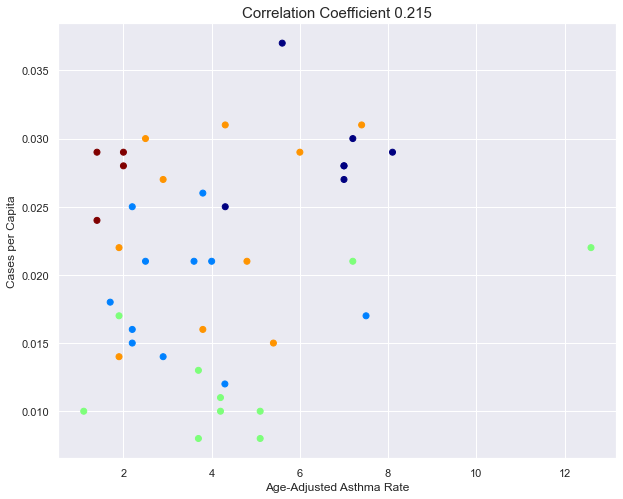

In [34]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(case_per_neighborhood['asthma_percent'],case_per_neighborhood['case_per_capita'],
            c= case_per_neighborhood['borough'].astype('category').cat.codes, 
            cmap = 'jet')

corr_coef = np.round(np.corrcoef(case_per_neighborhood['case_per_capita'],case_per_neighborhood['asthma_percent'])[0,1],3)

ax.set_title('Correlation Coefficient {}'.format(corr_coef), fontsize=15)
ax.set_xlabel('Age-Adjusted Asthma Rate', fontsize=12)
ax.set_ylabel('Cases per Capita', fontsize=12)

plt.show()

We don't really see a strong correlation between asthma level among adults and positive COVID-19 cases.

In [35]:
heart_attacks = pd.read_csv("data/Heart Attack Hospitalizations.csv")

heart_attacks.iloc[:,3] = heart_attacks.copy().iloc[:,3].str.strip()

heart_attacks['population_all'] = (heart_attacks['Number - Adults 35 to 64 Yrs Old'].str.replace(",","").astype(int)/(heart_attacks['Age-Adjusted Rate - Adults 35 to 64 Yrs Old (per 10,000 residents)']/100)
                                   + heart_attacks['Number - Adults 65 Yrs and Older'].str.replace(",","").astype(int)/(heart_attacks['Age-Adjusted Rate Adults - 65 Yrs and Older (per 10,000 residents)']/100))
 
heart_attacks['age_adjusted_rate_all'] = np.round((heart_attacks['Number - Adults 35 to 64 Yrs Old'].str.replace(",","").astype(int) 
                                           + heart_attacks['Number - Adults 65 Yrs and Older'].str.replace(",","").astype(int))
                                          / heart_attacks['population_all']*100, 1)


heart_attacks.head()

,Year,GeoTypeName,Borough,Geography,Geography ID,Indicator Name,"Age-Adjusted Rate - Adults 35 to 64 Yrs Old (per 10,000 residents)","Age-Adjusted Rate Adults - 65 Yrs and Older (per 10,000 residents)",Number - Adults 35 to 64 Yrs Old,Number - Adults 65 Yrs and Older,"Rate - Adults 35 to 64 Yrs Old (per 10,000 residents)","Rate - Adults 65 Yrs and Older (per 10,000 residents)",Notes Age-Adjusted Rate - Adults 35 to 64 Yrs Old,Notes Age-Adjusted Rate Adults - 65 Yrs and Older,Notes Number - Adults 35 to 64 Yrs Old,Notes Number - Adults 65 Yrs and Older,Notes Rate - Adults 35 to 64 Yrs Old,Notes Rate - Adults 65 Yrs and Older,population_all,age_adjusted_rate_all
0,2016,Borough,Bronx,Bronx,1,Heart Attack Hospitalizations,14.3,52.2,848,872,16.0,51.0,NaN,NaN,NaN,NaN,NaN,NaN,7600.568014,22.6
1,2016,Neighborhood (UHF 42),Bronx,Crotona-Tremont,105,Heart Attack Hospitalizations,15.8,59.1,136,104,17.5,54.8,NaN,NaN,NaN,NaN,NaN,NaN,1036.732421,23.1
2,2016,Neighborhood (UHF 42),Bronx,Fordham - Bronx Pk,103,Heart Attack Hospitalizations,12.8,50.5,129,123,14.0,50.1,NaN,NaN,NaN,NaN,NaN,NaN,1251.376856,20.1
3,2016,Neighborhood (UHF 42),Bronx,High Bridge - Morrisania,106,Heart Attack Hospitalizations,16.6,59.7,146,123,18.5,56.1,NaN,NaN,NaN,NaN,NaN,NaN,1085.548223,24.8
4,2016,Neighborhood (UHF 42),Bronx,Hunts Point - Mott Haven,107,Heart Attack Hospitalizations,19.8,79.4,105,112,21.6,76.6,NaN,NaN,NaN,NaN,NaN,NaN,671.360965,32.3


In [36]:
case_per_neighborhood = merge_df(case_per_neighborhood, heart_attacks[['Geography','age_adjusted_rate_all']], 
                                 left_on = 'uhf42_neigh',
                                 right_on='Geography')

case_per_neighborhood.rename(columns = {'age_adjusted_rate_all': "heart_attack_percent"}, inplace= True)

case_per_neighborhood.head()

,borough,uhf34_neigh,uhf42_neigh,population,positive_rate,case_per_capita,test_per_capita,obesity_percent,copd_rate,asthma_percent,heart_attack_percent
0,Queens,Bayside Little Neck-Fresh Meadows,Bayside - Little Neck,87423,35.44,0.014,0.040,53.4,11.7,1.9,11.7
1,Queens,Bayside Little Neck-Fresh Meadows,Fresh Meadows,95537,39.06,0.022,0.055,53.4,12.0,1.9,16.8
2,Brooklyn,Bedford Stuyvesant - Crown Heights,Bedford Stuyvesant - Crown Heights,316269,39.09,0.017,0.044,67.2,21.4,7.5,26.9
3,Brooklyn,Bensonhurst - Bay Ridge,Bensonhurst - Bay Ridge,201541,37.38,0.015,0.040,50.3,40.8,2.2,20.3
4,Brooklyn,Borough Park,Borough Park,322563,38.58,0.025,0.065,56.3,15.5,2.2,25.1


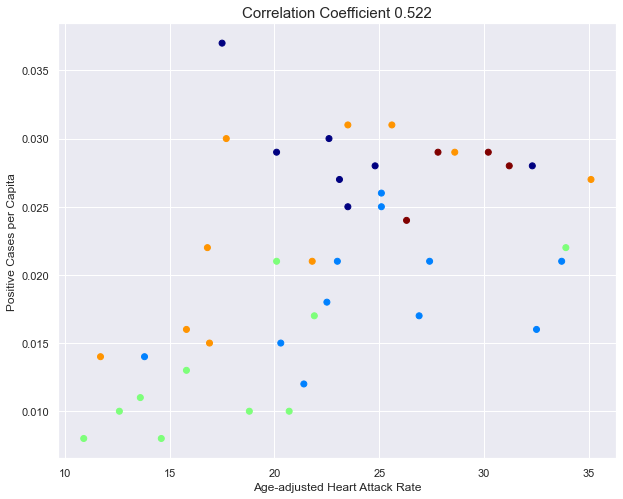

In [37]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(case_per_neighborhood['heart_attack_percent'],case_per_neighborhood['case_per_capita'],
            c= case_per_neighborhood['borough'].astype('category').cat.codes, 
            cmap = 'jet')

corr_coef = np.round(np.corrcoef(case_per_neighborhood['case_per_capita'],case_per_neighborhood['heart_attack_percent'])[0,1],3)

ax.set_title('Correlation Coefficient {}'.format(corr_coef), fontsize=15)
ax.set_xlabel('Age-adjusted Heart Attack Rate', fontsize=12)
ax.set_ylabel('Positive Cases per Capita', fontsize=12)

plt.show()

### Dimention Reduction - PCA

In [38]:
pca = PCA(n_components=2)

In [39]:
neighborhoods = case_per_neighborhood.iloc[:,0:3]
metrics = case_per_neighborhood.iloc[:,7:]

In [40]:
pca_transformed = pca.fit_transform(scale(metrics))

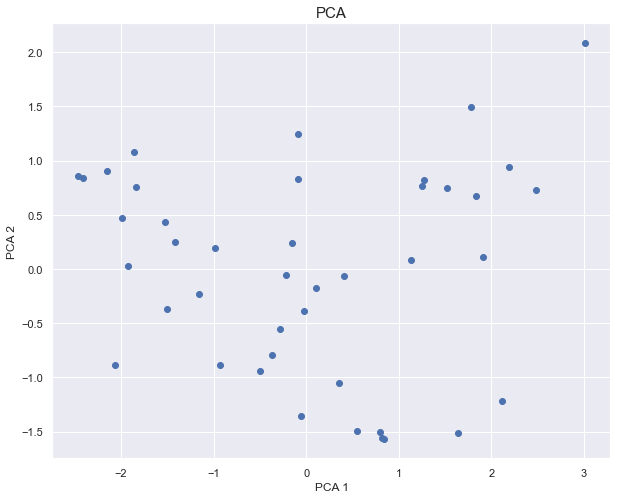

In [41]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(pca_transformed[:,0],pca_transformed[:,1])

corr_coef = np.round(np.corrcoef(case_per_neighborhood['case_per_capita'],case_per_neighborhood['heart_attack_percent'])[0,1],3)

ax.set_title('PCA', fontsize=15)
ax.set_xlabel('PCA 1', fontsize=12)
ax.set_ylabel('PCA 2', fontsize=12)

plt.show()

### Dimention Reduction - t-Distributed Stochastic Neighbouring

In [42]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(scale(metrics))

[t-SNE] Computing 41 nearest neighbors...
[t-SNE] Indexed 42 samples in 0.000s...
[t-SNE] Computed neighbors for 42 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 42 / 42
[t-SNE] Mean sigma: 4.565159
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.771568
[t-SNE] KL divergence after 300 iterations: 0.810743


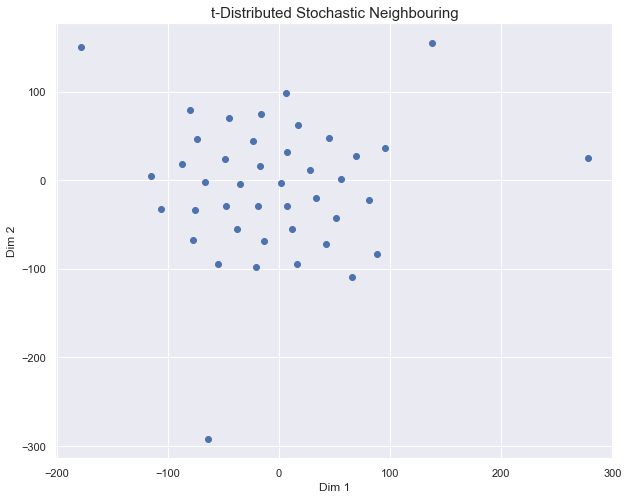

In [43]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(tsne_results[:,0],tsne_results[:,1])


ax.set_title('t-Distributed Stochastic Neighbouring', fontsize=15)
ax.set_xlabel('Dim 1', fontsize=12)
ax.set_ylabel('Dim 2', fontsize=12)

plt.show()

In [44]:
#Elbow Diagram

from scipy.spatial.distance import cdist 

distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(scale(metrics)) 
    kmeanModel.fit(scale(metrics))     
      
    distortions.append(sum(np.min(cdist(scale(metrics), kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / scale(metrics).shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(scale(metrics), kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / scale(metrics).shape[0] 
    mapping2[k] = kmeanModel.inertia_

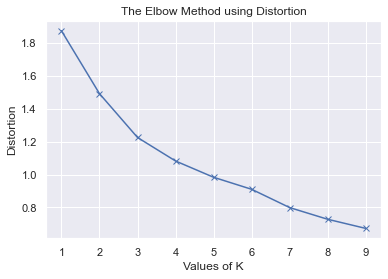

In [45]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

In [46]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(scale(metrics))
cluster_kmeans = kmeans.predict(scale(metrics))

In [47]:
case_per_neighborhood['cluster'] = cluster_kmeans

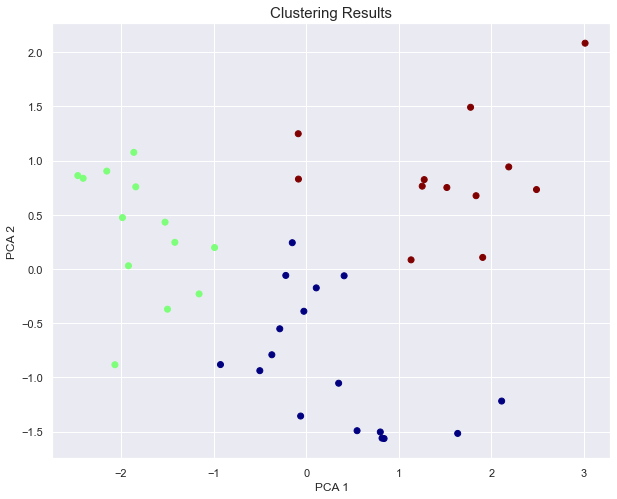

In [48]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(pca_transformed[:,0],pca_transformed[:,1],
            c= case_per_neighborhood['cluster'].astype('category').cat.codes, 
            cmap = 'jet')

corr_coef = np.round(np.corrcoef(case_per_neighborhood['case_per_capita'],case_per_neighborhood['heart_attack_percent'])[0,1],3)

ax.set_title('Clustering Results', fontsize=15)
ax.set_xlabel('PCA 1', fontsize=12)
ax.set_ylabel('PCA 2', fontsize=12)

plt.show()

In [49]:
cluser_0 = case_per_neighborhood[case_per_neighborhood['cluster'] == 0]

cluser_0.head()

,borough,uhf34_neigh,uhf42_neigh,population,positive_rate,case_per_capita,test_per_capita,obesity_percent,copd_rate,asthma_percent,heart_attack_percent,cluster
3,Brooklyn,Bensonhurst - Bay Ridge,Bensonhurst - Bay Ridge,201541,37.38,0.015,0.040,50.3,40.8,2.2,20.3,0
4,Brooklyn,Borough Park,Borough Park,322563,38.58,0.025,0.065,56.3,15.5,2.2,25.1,0
5,Brooklyn,Canarsie - Flatlands,Canarsie-Flatlands,191734,43.48,0.026,0.060,61.3,14.5,3.8,25.1,0
6,Manhattan,Central Harlem - Morningside Heights,Central Harlem - Morningside Heights,162238,35.05,0.017,0.050,52.4,33.1,1.9,21.9,0
9,Brooklyn,Coney Island - Sheepshead Bay,Coney Island-Sheepshead Bay,285275,39.62,0.021,0.052,60.6,26.2,2.5,27.4,0


In [50]:
cluser_1 = case_per_neighborhood[case_per_neighborhood['cluster'] == 1]

cluser_1.head()

,borough,uhf34_neigh,uhf42_neigh,population,positive_rate,case_per_capita,test_per_capita,obesity_percent,copd_rate,asthma_percent,heart_attack_percent,cluster
0,Queens,Bayside Little Neck-Fresh Meadows,Bayside - Little Neck,87423,35.44,0.014,0.040,53.4,11.7,1.9,11.7,1
1,Queens,Bayside Little Neck-Fresh Meadows,Fresh Meadows,95537,39.06,0.022,0.055,53.4,12.0,1.9,16.8,1
7,Manhattan,Chelsea-Village,Chelsea-Clinton,143506,29.83,0.013,0.045,36.7,17.8,3.7,15.8,1
8,Manhattan,Chelsea-Village,Greenwich Village - Soho,83664,27.32,0.008,0.029,36.7,15.4,3.7,10.9,1
10,Brooklyn,Downtown - Heights - Slope,Downtown-Heights -Slope,227057,30.64,0.012,0.039,44.2,19.2,4.3,21.4,1


In [51]:
cluser_2 = case_per_neighborhood[case_per_neighborhood['cluster'] == 2]

cluser_2.head()

,borough,uhf34_neigh,uhf42_neigh,population,positive_rate,case_per_capita,test_per_capita,obesity_percent,copd_rate,asthma_percent,heart_attack_percent,cluster
2,Brooklyn,Bedford Stuyvesant - Crown Heights,Bedford Stuyvesant - Crown Heights,316269,39.09,0.017,0.044,67.2,21.4,7.5,26.9,2
12,Manhattan,East Harlem,East Harlem,113291,40.11,0.022,0.055,62.0,40.4,12.6,33.9,2
15,Bronx,Fordham - Bronx Pk,Fordham - Bronx Pk,250249,43.39,0.029,0.066,65.1,51.3,8.1,20.1,2
17,Queens,Jamaica,Jamaica,292571,44.10,0.029,0.066,67.5,20.2,6.0,28.6,2
19,Queens,Long Island City - Astoria,Long Island City - Astoria,203963,34.89,0.015,0.044,60.0,26.2,5.4,16.9,2


In [52]:
cluster_0_means = np.mean(cluser_0)
cluster_1_means = np.mean(cluser_1)
cluster_2_means = np.mean(cluser_2)

In [53]:
cluster_means = pd.concat([cluster_0_means,cluster_1_means,cluster_2_means ], axis = 1)

cluster_means.rename(columns = {0: 'Cluster 0', 1: 'Cluster 1', 2: 'Cluster 2'}, inplace = True)

cluster_means

,Cluster 0,Cluster 1,Cluster 2
population,192680.235294,179754.461538,215331.250000
positive_rate,39.127059,33.063846,41.044167
case_per_capita,0.023176,0.013692,0.026167
test_per_capita,0.059294,0.040692,0.063417
obesity_percent,58.976471,43.592308,68.475000
copd_rate,27.947059,14.384615,33.083333
asthma_percent,2.777399,3.415385,7.333333
heart_attack_percent,26.523529,15.707692,24.366667
cluster,0.000000,1.000000,2.000000


Cluster 1 is clearly a better a safer cluster given much lower cases, case per capita with other health conditions show to be better as well.

Cluster 0 has most average cases per capita and it also has the highest rate in obesity, copd, and heart attack. So this cluster seems to be the most unhealthy cluster.

In [54]:
cluser_0.groupby('borough')['uhf42_neigh'].count()

borough
Bronx            1
Brooklyn         8
Manhattan        1
Queens           3
Staten Island    4
Name: uhf42_neigh, dtype: int64

All of Bronx and Staten Island neighborhoods are in Cluster 0.

In [55]:
cluser_1.groupby('borough')['uhf42_neigh'].count()

borough
Brooklyn     2
Manhattan    7
Queens       4
Name: uhf42_neigh, dtype: int64

Most neighborhoods in Manhattan are in Cluster 1.

In [56]:
cluser_2.groupby('borough')['uhf42_neigh'].count()

borough
Bronx        6
Brooklyn     1
Manhattan    2
Queens       3
Name: uhf42_neigh, dtype: int64

Queens dominated Cluster 2.

Comparing between 2 high-risk factors

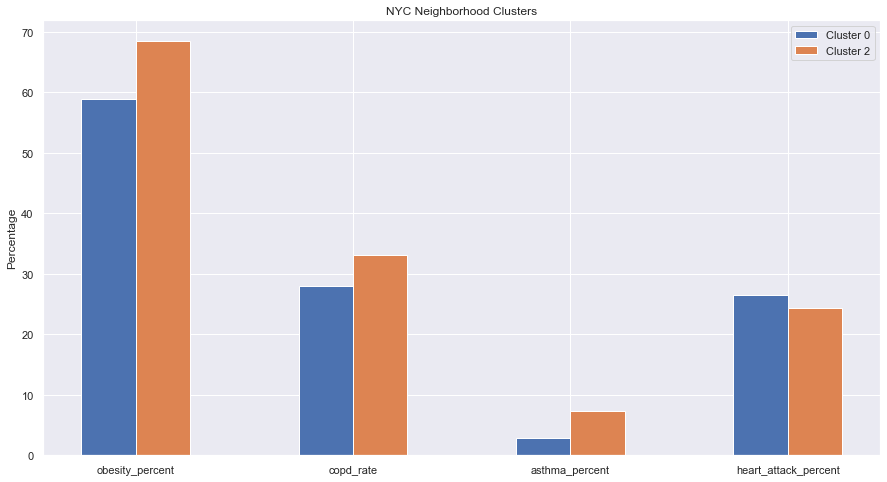

In [67]:
labels = case_per_neighborhood.columns[7:-1]

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(15, 8))
rects1 = ax.bar(x - width/2, cluster_means.iloc[4:-1,0], width, label='Cluster 0')
rects3 = ax.bar(x + width/2, cluster_means.iloc[4:-1,2], width, label='Cluster 2')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage')
ax.set_title('NYC Neighborhood Clusters')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

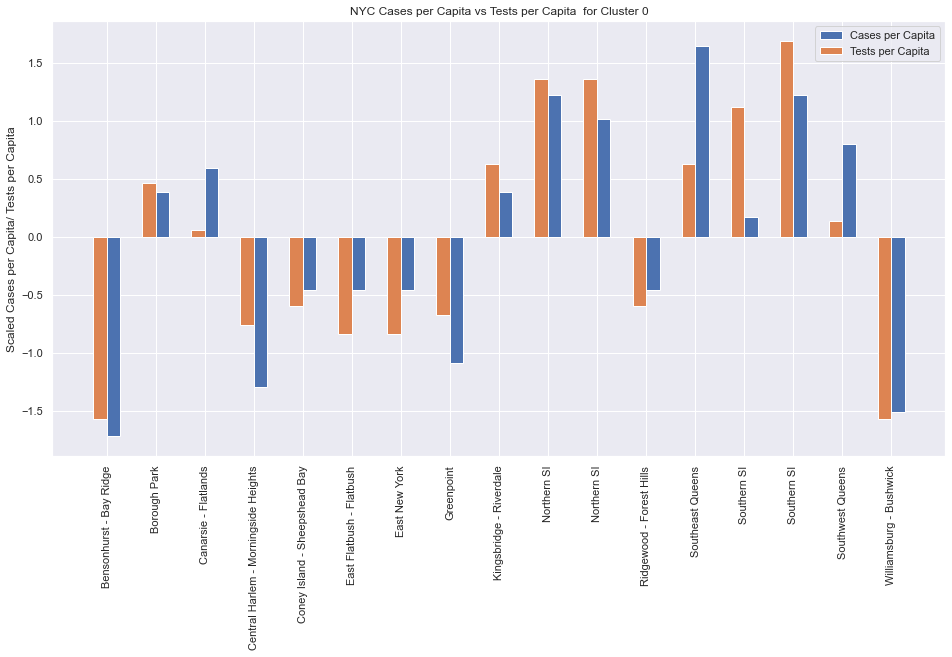

In [73]:
labels = cluser_0['uhf34_neigh'] #UHF34 Neighborhoods

x = np.arange(len(labels))  # the label locations
width = 0.275  # the width of the bars


scaled_positive_rate = scale(cluser_0['case_per_capita'])
scaled_test_per_capita = scale(cluser_0['test_per_capita'])

fig, ax = plt.subplots(figsize=(16, 8))
rects1 = ax.bar(x + width/2, scaled_positive_rate, width, label='Cases per Capita')
rects2 = ax.bar(x - width/2, scaled_test_per_capita, width, label='Tests per Capita')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scaled Cases per Capita/ Tests per Capita')
ax.set_title('NYC Cases per Capita vs Tests per Capita  for Cluster 0')
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.xticks(rotation=90)

ax.legend()

plt.show()

Canerise - Flatlands and Southeast Queens seem to be under-tested.

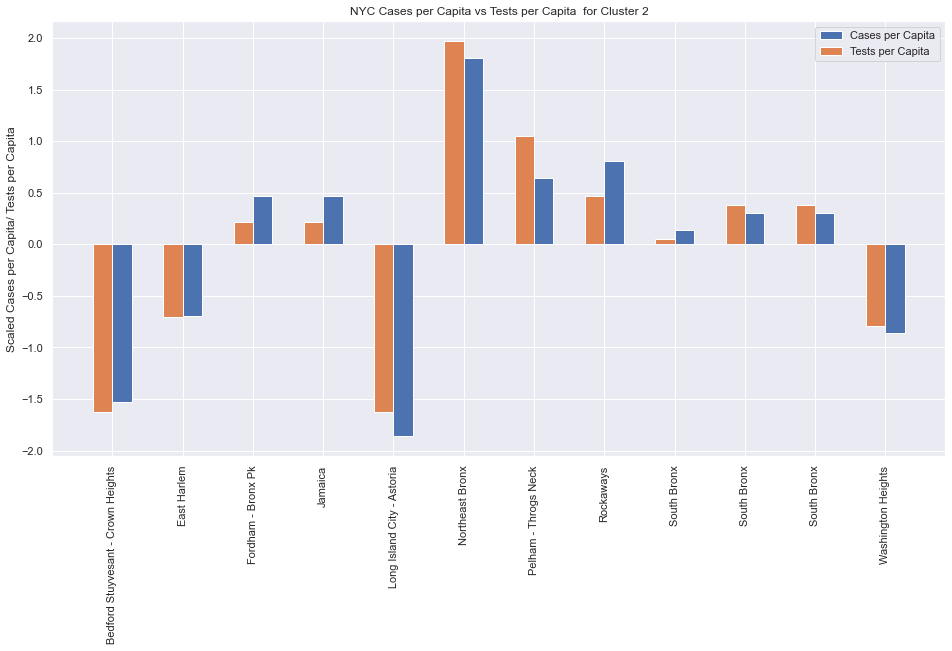

In [72]:
labels = cluser_2['uhf34_neigh'] #UHF34 Neighborhoods

x = np.arange(len(labels))  # the label locations
width = 0.275  # the width of the bars


scaled_positive_rate = scale(cluser_2['case_per_capita'])
scaled_test_per_capita = scale(cluser_2['test_per_capita'])

fig, ax = plt.subplots(figsize=(16, 8))
rects1 = ax.bar(x + width/2, scaled_positive_rate, width, label='Cases per Capita')
rects2 = ax.bar(x - width/2, scaled_test_per_capita, width, label='Tests per Capita')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scaled Cases per Capita/ Tests per Capita')
ax.set_title('NYC Cases per Capita vs Tests per Capita  for Cluster 2')
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.xticks(rotation=90)

ax.legend()

plt.show()

Jamaica, Fordham - Bronx Park, and Rockaways seem to be under-tested.

In [58]:
case_per_MODZCTA = test_by_zip.merge(case_per_neighborhood, left_on = 'uhf42_neigh', right_on = 'uhf42_neigh')

case_per_MODZCTA.head()

,MODZCTA,Positive,Total,zcta_cum.perc_pos,uhf34_neigh_x,uhf42_neigh,borough,uhf34_neigh_y,population,positive_rate,case_per_capita,test_per_capita,obesity_percent,copd_rate,asthma_percent,heart_attack_percent,cluster
0,10001,321,1130,28.41,Chelsea-Village,Chelsea-Clinton,Manhattan,Chelsea-Village,143506,29.83,0.013,0.045,36.7,17.8,3.7,15.8,1
1,10011,478,1606,29.76,Chelsea-Village,Chelsea-Clinton,Manhattan,Chelsea-Village,143506,29.83,0.013,0.045,36.7,17.8,3.7,15.8,1
2,10018,196,626,31.31,Chelsea-Village,Chelsea-Clinton,Manhattan,Chelsea-Village,143506,29.83,0.013,0.045,36.7,17.8,3.7,15.8,1
3,10019,547,1832,29.86,Chelsea-Village,Chelsea-Clinton,Manhattan,Chelsea-Village,143506,29.83,0.013,0.045,36.7,17.8,3.7,15.8,1
4,10036,377,1240,30.40,Chelsea-Village,Chelsea-Clinton,Manhattan,Chelsea-Village,143506,29.83,0.013,0.045,36.7,17.8,3.7,15.8,1


In [59]:
nyc_map = gpd.read_file('data/Geography-resources/MODZCTA_2010_WGS1984.geo.json')

nyc_map = nyc_map.merge(case_per_MODZCTA, left_on = 'MODZCTA', right_on = 'MODZCTA')

In [60]:
nyc_map['coords'] = nyc_map['geometry'].apply(lambda x: x.centroid.coords[:])
nyc_map['coords'] = [coords[0] for coords in nyc_map['coords']]

In [61]:
#Tranforming Pandas DF back to GeoDF

crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(nyc_map, crs=crs, geometry=nyc_map['geometry'])

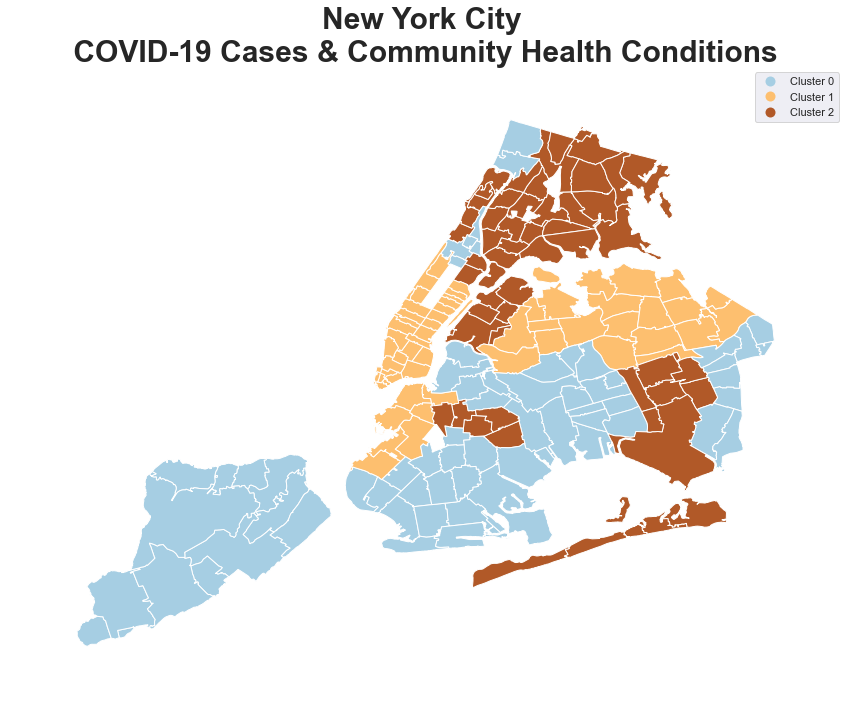

In [65]:
scheme = mc.Quantiles(gdf['cluster'], k=3)

geoplot.choropleth(gdf, hue='cluster',scheme = scheme, cmap='Paired',legend=True,legend_values = [0,1,2],
                        legend_labels = ['Cluster 0', 'Cluster 1', 'Cluster 2'],
                        figsize=(15, 15))

plt.title("New York City \n COVID-19 Cases & Community Health Conditions ",fontdict = {'weight': 'bold', 'size': 30})
                     
plt.show()

In [66]:
case_per_neighborhood.to_csv('data/case_per_neighborhood.csv', index=False, encoding='utf-8')